In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime
import glob
import imageio
import PIL
from tensorflow.keras import layers
import time
from IPython import display

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)

!pip install -q imageio

# Generative adversarial network (GAN)

So far we have looked at a few *generative* models. A generative model learns the structure of a set of input data. In doing so, the model learns to generate new data that it has never seen before in the training data.

A generative adversarial network (GAN) model consists of two models:
* A **Generator** network  **G**  that takes in a latent embedding (usually random noise) and generates an image like those that exists in the training data
* A **Discriminator** network  **D**  that tries to distinguish between real images from the training data, and fake images produced by the generator

In essence, we have two neural networks that are adversaries: the generator wants to fool the discriminator, and the discriminator wants to avoid being fooled.

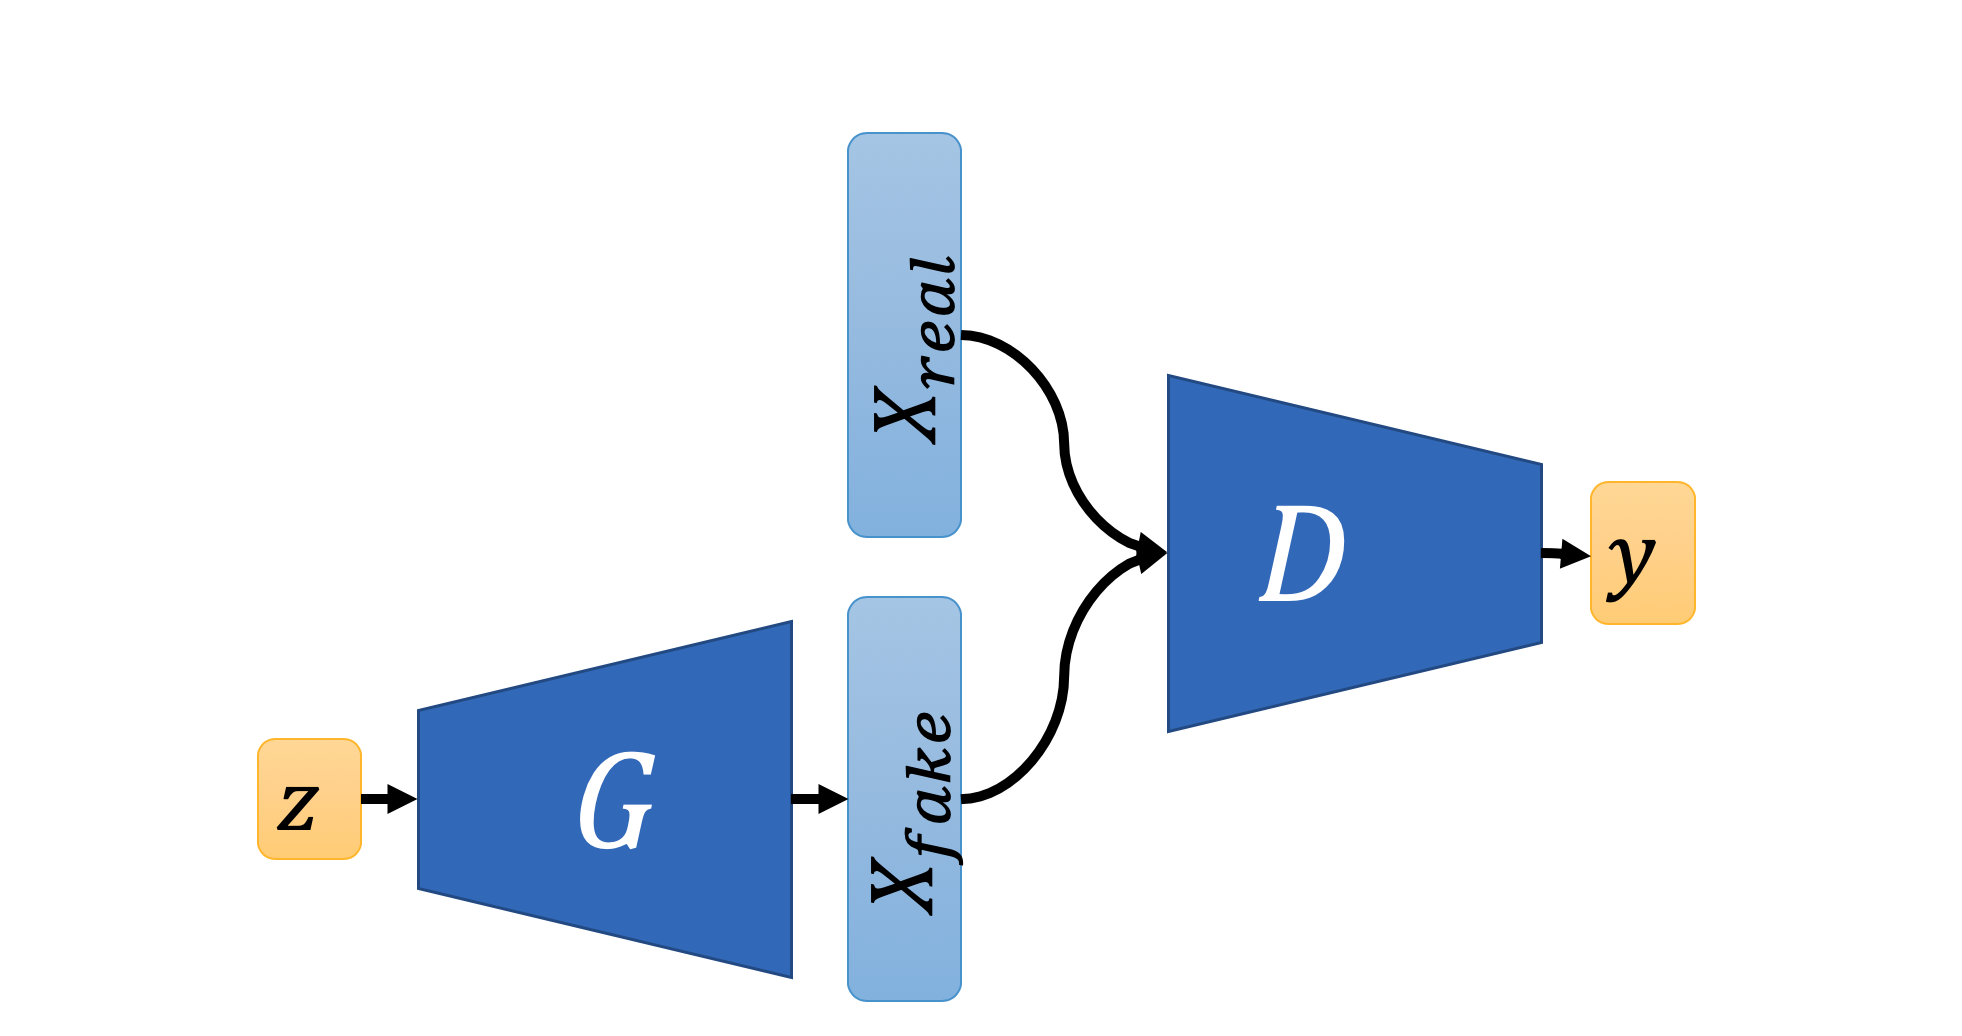

The generative network generates candidates while the discriminative network evaluates them. The contest operates in terms of data distributions. Typically, the generative network learns to map from a latent space to a data distribution of interest, while the discriminative network distinguishes candidates produced by the generator from the true data distribution. The generative network's training objective is to increase the error rate of the discriminative network (i.e., "fool" the discriminator network by producing novel candidates that the discriminator thinks are not synthesized (are part of the true data distribution)).

A known dataset serves as the initial training data for the discriminator. Training it involves presenting it with samples from the training dataset, until it achieves acceptable accuracy. The generator trains based on whether it succeeds in fooling the discriminator. Typically the generator is seeded with randomized input that is sampled from a predefined latent space (e.g. a multivariate normal distribution). Thereafter, candidates synthesized by the generator are evaluated by the discriminator. Backpropagation is applied in both networks so that the generator produces better images, while the discriminator becomes more skilled at flagging synthetic images. The generator is typically a deconvolutional neural network, and the discriminator is a convolutional neural network.

If we let $D$ denote the discriminator's predicted probability of being data, then the discriminator's cost function is the cross-entropy loss for the task of classifying real versus fake images

$$ \mathcal{J}_D=\mathop{\mathbb{E}_{x\sim \mathcal{D}}}[-log D(x)] + \mathop{\mathbb{E}_{z}}[-log(1-D(G(z)))]$$

One possible cost function for the generator is the opposite of the discriminator's

$$ \mathcal{J}_G = -\mathcal{J}_D $$
$$ \mathcal{J}_G = const + \mathop{\mathbb{E}_z}[log(1-D(G(z)))] $$


This is called the **minimax formulation**, since the generator and discriminator are playing a **zero-sum game** against each other:

$$ \max\limits_{G} \min\limits_{D} \mathcal{J}_D $$

GANs often suffer from a "mode collapse" where they fail to generalize properly, missing entire modes from the input data. For example, a GAN trained on the MNIST dataset containing many samples of each digit, might nevertheless timidly omit a subset of the digits from its output. Some researchers perceive the root problem to be a weak discriminative network that fails to notice the pattern of omission, while others assign blame to a bad choice of objective function. Many solutions have been proposed.

## GANs in Keras

Let's train a GAN using the MNIST dataset, which we can use to generate new digits images.

### The Generator

Similarly structured the decoder architecture that we saw in autoencoders. The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise in the latent space). We start with a `Dense` layer that takes this seed as input, then upsample several times until we reach the desired image size of $28 \times 28 \times 1$. Here we are using the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses *tanh*.

In [2]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

We can test the untrained generator to create an image

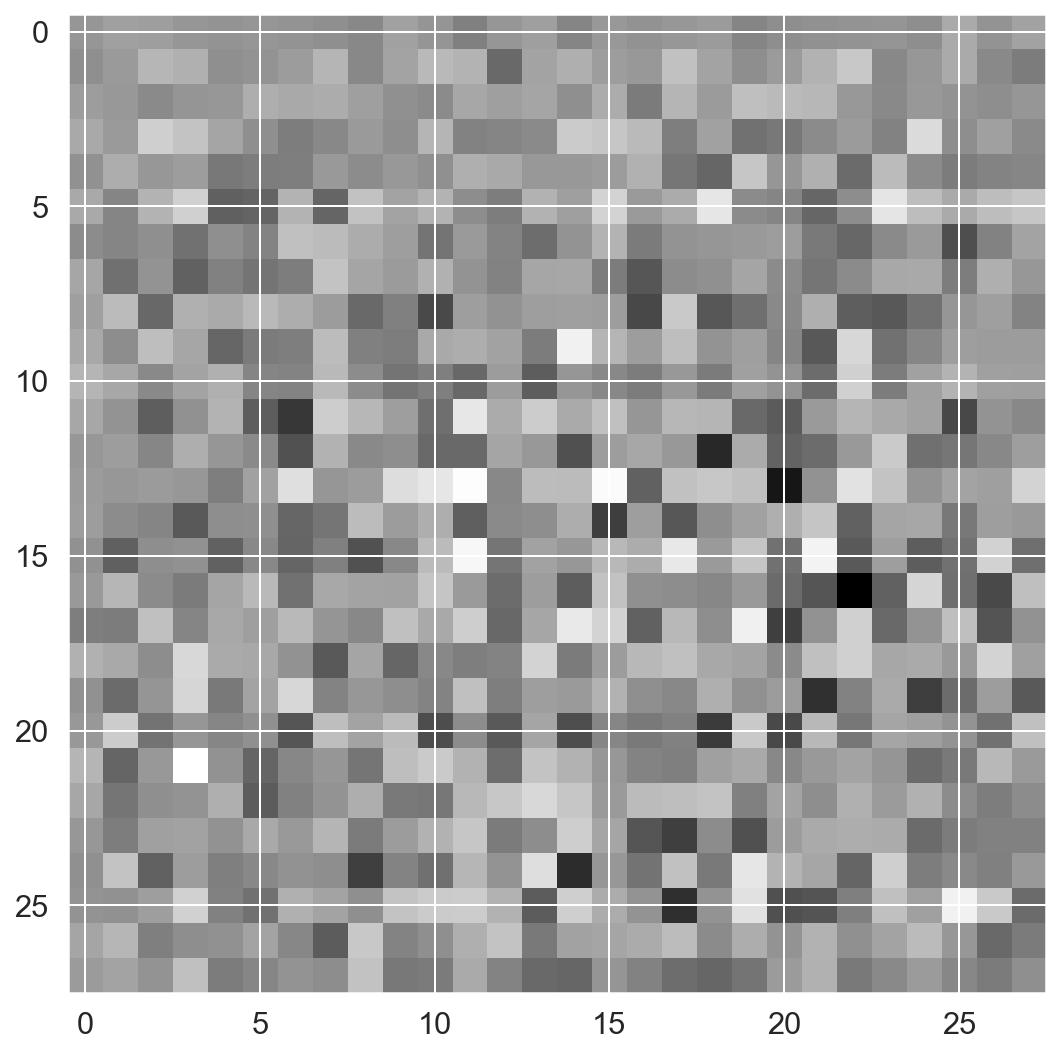

In [3]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

### The Discriminator

The discriminator is a ConvNet image classifier

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

We will use the discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

We can test the untrained model on our generated image above as follows

In [5]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.0020445]], shape=(1, 1), dtype=float32)


### Discriminator loss

The discriminators loss function which aims to distinguish real images from fakes, works by comparing the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [6]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

The generators loss function aims to create images that can fool the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [7]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [8]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Define the training loop


In [9]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime, so it's easier to visualise the progress of the traininig later
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models and the gradients are used to update the generator and discriminator.

In [10]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled", which speeds up training
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

##### Save checkpoints (Best practice)
It is best practice to save and restore models, which can be helpful in case a long running training task is interrupted.

In [11]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

def train(dataset, epochs):
    history = []
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            (gen_loss, disc_loss) = train_step(image_batch)

        display.clear_output(wait=True)
        generate_images(generator,
                         epoch + 1,
                         seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(
            epoch + 1, time.time()-start))
        history.append({'gen_loss': gen_loss.numpy(), 'disc_loss': disc_loss.numpy(), 'epoch': epoch})

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_images(generator,
                     epochs,
                     seed)
    return pd.DataFrame(history)

**Generate and save images**


In [12]:
def generate_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

## Training the GAN
We train the generator and discriminator simultaneously, from our defined `train` function above. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (we want them to train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits.

### Load and prepare the dataset

We use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [13]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

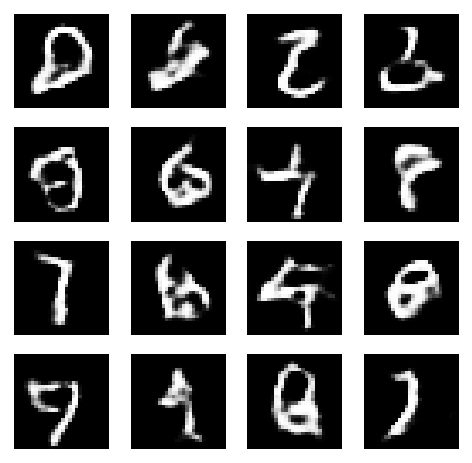

In [14]:
history = train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [15]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

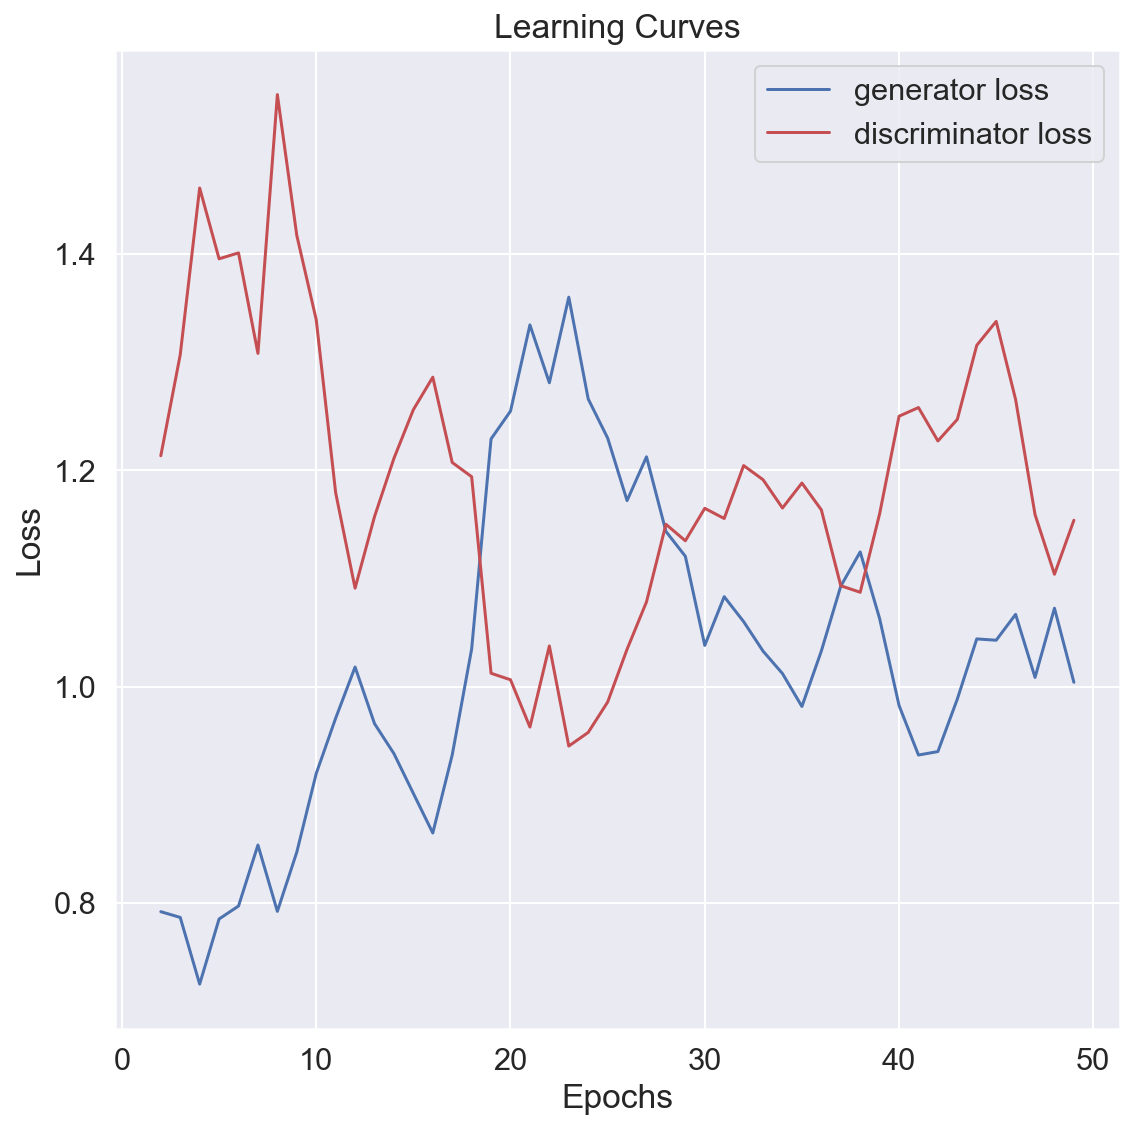

In [19]:
fig = plt.Figure(figsize=(4, 3))

epochs_to_mean = 3

plt.plot(history['gen_loss'].rolling(epochs_to_mean).mean(), 'b')
plt.plot(history['disc_loss'].rolling(epochs_to_mean).mean(), '-r')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['generator loss', 'discriminator loss'])
plt.show()

GANs are notoriously difficult to train. One difficulty is that a training curve is no longer as helpful as it was for a supervised learning problem. The generator and discriminator losses tend to bounce up and down, since both the generator and discriminator are changing over time. Tuning hyperparameters is also much more difficult, as we do not have the training curve to guide us. Newer GAN models like [Wasserstein GAN](https://arxiv.org/abs/1701.07875) tries to alleviate some of these issues.

To compound the difficulty of hyperparameter tuning GANs also take a long time to train. It is tempting to stop training early, but the effects of hyperparameters may not be noticeable until later on in training.

You might have noticed in the images generated by our simple GAN that the model seems to only output a small number of digit types. This phenomenon is called mode collapse. A generator can optimize the probability that the discriminator correctly identifies the image generated by the generator by learning to generate one type of input (e.g. one digit) really well, and not learning how to generate other digits at all.

## Exploring the GAN latent space

We can easily generate a random vector in the latent space and use the generator to generate an image, such as:

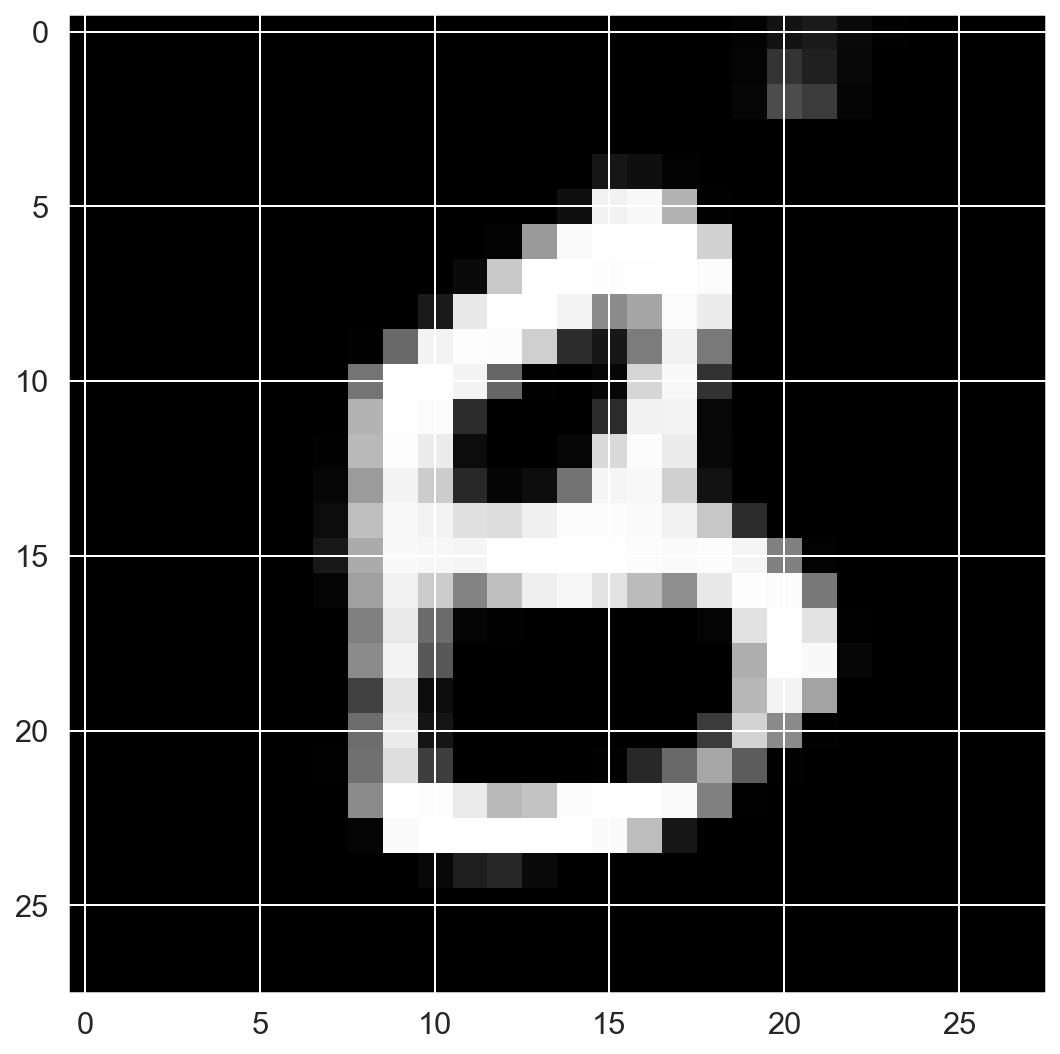

In [52]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

We can treat a latent space sample as a vector, this allows us to interpolate between two generated images, by interpolating between their samples latent vectors for the generator.

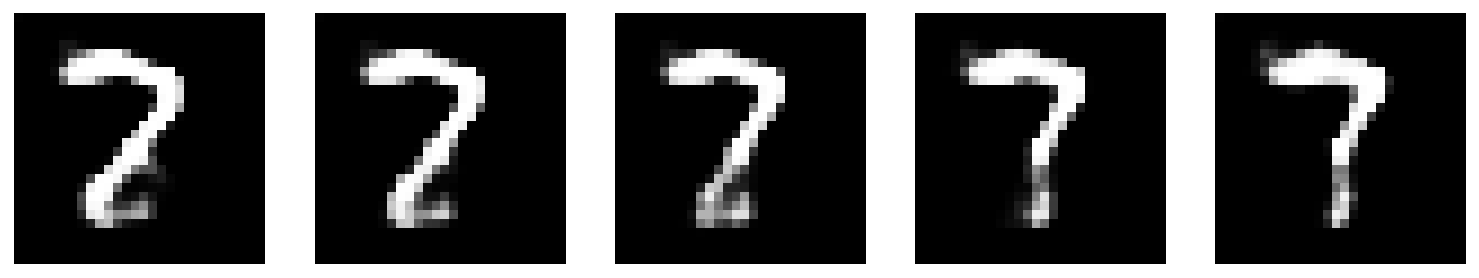

In [36]:
def linear_interpolate_vectors(p1, p2, steps):
    ratios = np.linspace(0, 1, steps)
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.asarray(vectors)

steps = 5

fig = plt.figure(figsize=(13,5))
for i, latent_vector in enumerate(linear_interpolate_vectors(tf.random.normal([1, 100]), tf.random.normal([1, 100]), steps)):
    X = generator(latent_vector)
    plt.subplot(1, steps, 1 + i)
    plt.axis('off')
    plt.imshow(X[0, :, :, 0], cmap='gray')
plt.show()